In [3]:
from sqlalchemy import create_engine
from config_loader import cf as config
from pprint import pprint

dbURL = config.get('MYSQL_DB', 'conn')
engine = create_engine(dbURL, encoding='utf-8', connect_args={'auth_plugin': 'mysql_native_password'})

In [5]:
sample = engine.execute("select * from tickers limit 10").fetchall()
# print(sample.fetchall())

findBest = lambda x: max(zip([t[8] for t in x], x))
stock = findBest(sample)

In [3]:
import pandas as pd
companies = pd.read_sql_query('select * from base_stocks', con = engine)

In [4]:
trade_dt = '20200720'
tkDF = pd.read_sql_query('select * from tickers where trade_date = "{}"'.format(trade_dt), con = engine, parse_dates=['trade_date'])

In [5]:
stocks, p_close, p_chg, vols = list(tkDF['ts_code']), list(tkDF['close']), list(tkDF['pct_chg']), list(tkDF['vol'])
s_id, s_name, s_area, s_ind, s_mkt = list(companies['ts_code']), list(companies['name']), list(companies['area']), list(companies['industry']), list(companies['market'])
names = dict(zip(s_id, s_name))
areas = dict(zip(s_id, s_area))
industries = dict(zip(s_id, s_ind))
markets = dict(zip(s_id, s_mkt))

In [6]:
# getTopVols = lambda tops: sorted({p[0]:'{}:{}'.format(p[0], p[1]) for p in zip(vols, stocks)}, reverse=True)[:tops]
# x = getTopVols(10)
# x
# max(zip(vols, stocks))
# companies[companies['ts_code']=='000725.SZ']
getTops = lambda idx, tops: (sorted(zip(stocks, idx), key=lambda x:(x[1]), reverse=True)[:tops])
pprint(companies[companies['ts_code']=='000725.SZ'])
pprint([(x, industries.get(x[0])) for x in getTops(p_chg, 10)])

ts_code  symbol  name area industry market list_date
266  000725.SZ  000725  京东方A   北京      元器件     主板  20010112
[(('688256.SH', 229.8649), '元器件'),
 (('688488.SH', 121.015), '生物制药'),
 (('300848.SZ', 44.0028), '化工原料'),
 (('688186.SH', 17.3657), '特种钢'),
 (('601600.SH', 10.1587), '铝'),
 (('600496.SH', 10.1235), '钢加工'),
 (('300080.SZ', 10.1075), '半导体'),
 (('600409.SH', 10.099), '化工原料'),
 (('688002.SH', 10.0976), '通信设备'),
 (('000488.SZ', 10.0952), '造纸')]


In [7]:
stockDF = pd.read_sql_query('select * from tickers where ts_code = "{}"'.format("000725.SZ"), con = engine, parse_dates=['trade_date'])
close_price = list(stockDF['close'])
trade_date = list(stockDF['trade_date'])
pp_array = [(pre, next) for pre,next in zip(close_price[:-1], close_price[1:])]

In [8]:
# change_array = map(lambda pp: reduce(lambda a, b: round((b-a)/a, 3), pp), pp_array)
change_array = list(map(lambda x: round((x[1]-x[0])*100/x[0], 2), pp_array))
change_array.insert(0, 0)

In [9]:
# change_array.insert(0, 0)
list(zip(map(lambda f: f.strftime('%Y%m%d'), trade_date), change_array))[:20]

[('20150105', 0),
 ('20150106', 0.87),
 ('20150107', -0.29),
 ('20150108', -2.01),
 ('20150109', -2.35),
 ('20150112', -3.3),
 ('20150113', 1.55),
 ('20150114', -2.45),
 ('20150115', 2.19),
 ('20150116', 0.92),
 ('20150119', -8.51),
 ('20150120', 2.99),
 ('20150121', 2.9),
 ('20150122', 0.0),
 ('20150123', -1.25),
 ('20150126', 1.27),
 ('20150127', 0.31),
 ('20150128', -1.25),
 ('20150129', -0.95),
 ('20150130', -0.64)]

In [11]:
from collections import namedtuple, OrderedDict

stock_tuple = namedtuple('stock', ('date', 'price', 'change'))
# [ (trd_dt, stock_tuple(trd_dt, price, change)) for trd_dt, price, change in zip(map(lambda t: t.strftime('%Y%m%d'), trade_date), close_price, change_array]
stock_dict = OrderedDict((trd_dt, stock_tuple(trd_dt, price, change)) for trd_dt, price, change in zip(map(lambda t: t.strftime('%Y%m%d'), trade_date), close_price, change_array))

In [36]:
# stock_dict
# a = list(stock_dict.values())[1].change
x = filter(lambda x: x.change > 0, stock_dict.values())
sum([x.change for x in x])

1306.36

In [43]:
from functools import partial

def filter_stock(stock_dict, up_or_down, sum_flag):
    if not isinstance(stock_dict, OrderedDict):
        raise TypeError('stock_dict must be OrderedDict')
    wanted_stocks = filter(lambda x: x.change > 0 if up_or_down else x.change <= 0, stock_dict.values())
    if not sum_flag:
        return OrderedDict({x.date:x for x in wanted_stocks})
    else:
        return sum([x.change for x in wanted_stocks])

filter_up_sum = partial(filter_stock, up_or_down=True, sum_flag=True)
filter_down_sum = partial(filter_stock, up_or_down=False, sum_flag=True)

In [46]:
# filter_stock(stock_dict, up_or_down=True, sum_flag=False)
# filter_up_sum(stock_dict)
# filter_down_sum(stock_dict)
# locals()
len(filter_stock(stock_dict, up_or_down=True, sum_flag=False))
len(filter_stock(stock_dict, up_or_down=False, sum_flag=False))

745

In [3]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

from trade_loopback import TradeLoopBack
from trade_days import TradeDays
from trade_strategies.base_strategy import GamblerStrategy
from trade_strategies.mean_strategy import MeanStrategy

In [6]:
trade_days = TradeDays(code='000001.SZ', base_date='20190101')
loopback = TradeLoopBack(trade_days, MeanStrategy())
loopback.execute_trade()
print('{:.2f}%'.format(reduce(lambda a, b: a + b, loopback.profit_days)))

buy on 2019-05-06, at 12.87
sell on 2019-05-31, with profits chg -5.11
buy on 2020-02-03, at 13.99
sell on 2020-02-14, with profits chg 7.33
buy on 2020-03-19, at 12.23
sell on 2020-03-27, with profits chg 7.43
9.65%


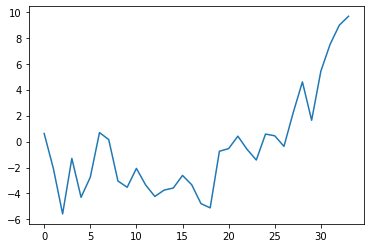

In [7]:
plt.plot(np.array(loopback.profit_days).cumsum())